In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bengali-review-dataset/Bengali Review Dataset.csv


## Importing necessary Modules

In [56]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D
# from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

## Importing Dataset

In [9]:
reviews.head()

,Reviews,Sentiment
0,অসাধারণ নিশো বস্ আর অমি ভাইকেও।,positive
1,"""এত মোটা বাশ নিতে পারছি না বাবা """,negative
2,নাটক আসলেই অসাধারণ,positive
3,ফালতু একটা নাটক,negative
4,ধুমপান সাস্থর জন্য ক্ষতিকর।,negative


## Plotting Data

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

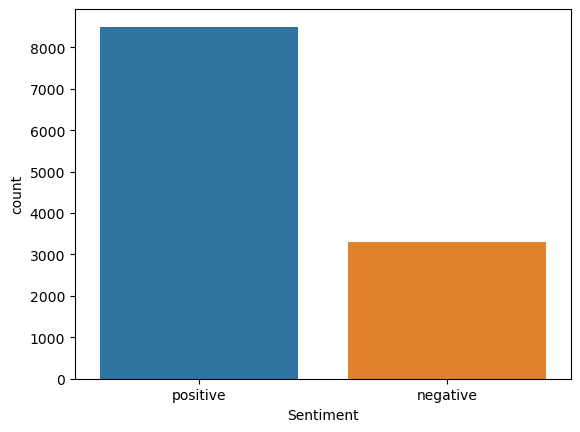

In [10]:
import seaborn as sns
sns.countplot(x = 'Sentiment', data = reviews)

## Trying to remove stopwords

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash
import sparknlp

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

In [19]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [ ]:

nlp_pipeline = Pipeline(stages=[document_assembler, tokenizer, stop_words])
light_pipeline = LightPipeline(nlp_pipeline.fit(spark.createDataFrame([['']]).toDF("text")))
results = light_pipeline.fullAnnotate("উত্তরের রাজা হওয়া ছাড়াও জন স্নো একজন ইংরেজ চিকিত্সক এবং অবেদন এবং মেডিকেল হাইজিনের বিকাশের এক নেতা")

In [27]:
stop_words = StopWordsCleaner.pretrained("stopwords_bn", "bn") \
        .setInputCols(["token"]) \
        .setOutputCol("cleanTokens")
test = "উত্তরের রাজা হওয়া ছাড়াও জন স্নো একজন ইংরেজ চিকিত্সক এবং অবেদন এবং মেডিকেল হাইজিনের বিকাশের এক নেতা"


sparknlp.annotator.stop_words_cleaner.StopWordsCleaner

## Preprocessing

In [32]:
X = reviews['Reviews'].to_numpy()

In [33]:
X

array([' অসাধারণ নিশো বস্ আর অমি ভাইকেও।',
       ' "এত মোটা বাশ নিতে পারছি না বাবা "', ' নাটক আসলেই অসাধারণ', ...,
       ' ভাই আপনাদের এত স্পন্সর দরকার তাহলে Youtube নাটক দিছেন কেন ? নাটক ভালো ছিল But দেখে শান্তি পাইলাম না',
       'এগুলো কি নাটক না কি', ' অনেক বেশি ভালো লাগল'], dtype=object)

In [31]:
y

array([1, 0, 1, ..., 1, 0, 1])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.10, random_state = 42)

In [108]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [109]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [110]:
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

### Model Building and Training

In [133]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'sigmoid'),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [134]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                1088      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

In [136]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)

In [137]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
333/333 [==============================] - 3s 7ms/step - loss: 0.6006 - accuracy: 0.7171 - val_loss: 0.5733 - val_accuracy: 0.7011
Epoch 2/20
333/333 [==============================] - 2s 7ms/step - loss: 0.3511 - accuracy: 0.8499 - val_loss: 0.2347 - val_accuracy: 0.9145
Epoch 3/20
333/333 [==============================] - 2s 7ms/step - loss: 0.1684 - accuracy: 0.9388 - val_loss: 0.1894 - val_accuracy: 0.9297
Epoch 4/20
333/333 [==============================] - 2s 7ms/step - loss: 0.1210 - accuracy: 0.9597 - val_loss: 0.1784 - val_accuracy: 0.9340
Epoch 5/20
333/333 [==============================] - 2s 7ms/step - loss: 0.0945 - accuracy: 0.9680 - val_loss: 0.1975 - val_accuracy: 0.9306
Epoch 6/20
333/333 [==============================] - 2s 6ms/step - loss: 0.0753 - accuracy: 0.9748 - val_loss: 0.2186 - val_accuracy: 0.9136
Epoch 7/20
333/333 [==============================] - 2s 7ms/step - loss: 0.0623 - accuracy: 0.9807 - val_loss: 0.1844 - val_accuracy: 0.9416
Epoch 

## Plotting Accuracy, Loss, Val_Accuracy, Val_Loss

<Figure size 640x480 with 0 Axes>

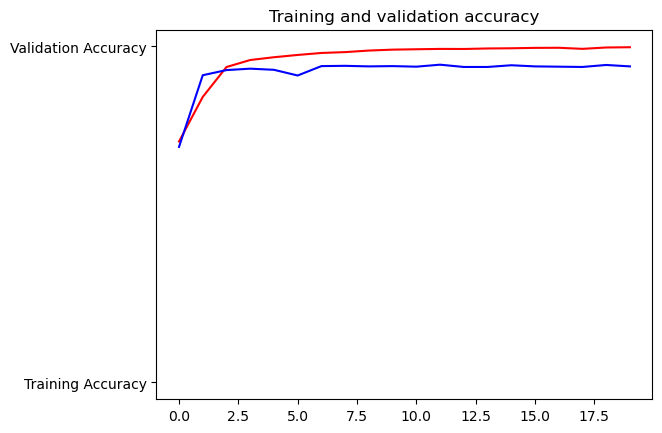

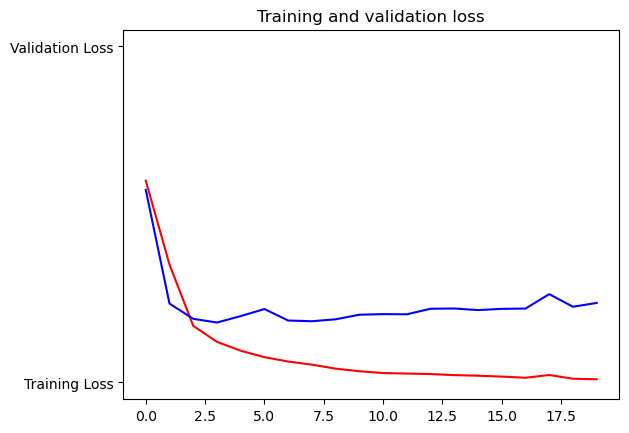

<Figure size 640x480 with 0 Axes>

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

## Creating a custom dataset and testing out model prediction

In [157]:
test = np.array(['অসাধারণ অমি ভাই', 'অনেক বাশ লাগল', 'শান্তি পাইলাম না'])
print(test)
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
test = tokenizer.texts_to_sequences(test)
test = pad_sequences(test, maxlen=max_length)
print(test)

['অসাধারণ অমি ভাই' 'অনেক বাশ লাগল' 'শান্তি পাইলাম না']
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     4   237     7]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0 

In [158]:
model.predict(test)

1/1 [==============================] - 0s 21ms/step


array([[0.9998481 ],
       [0.37675896],
       [0.06277245]], dtype=float32)

Here the values close to 1 are positive and close to 0 are negative.
So, the model is predicting the test data very well.